# 说明

深度学习图像处理的核心研究内容：1.图像定位、2.语义分割
- 图像定位：分类 + 定位 —— 不仅要知道图片中对象是什么（分类），还要在对象所在位置附近画一个**边框**，即确定该对象在图片中所处的位置（定位）。
- 语义分割：分类 + 分割 —— 对图中**每个像素点**进行分类，而不仅仅是用矩形框框柱其大概范围！
- 目标检测：有哪些实体、每个实体用边框圈起来；—— Fast-RCNN、Yolo
- 实例分割：目标检查 + 语义分割：每个独立的个体，都要对其像素进行标注 —— Mask-RCNN

---
数据集介绍：The Oxford-IIIT Pet Dataset：宠物图像数据集（尺寸不一），包含37种宠物，每种200张大小不一。此外还包含宠物分类、头部轮廓标注、语义分割信息。—— 头部轮廓.xml浏览器文件，需要lxml包来查看！

图像定位：
- 要输出4个数字(x,y,w,h)：某点的坐标(x,y)、图像的宽度、图像的通道数 —— 这有这4个数字，就可以把物体（矩形）边界找到！
- 两分支网络：一个分支进行**分类**，一个分支进行4个数字的**回归预测**！
- 控制点4个参数xmin、ymin、xmax、ymax是回归问题！即预测一个数值！

In [1]:
from lxml import etree
import tensorflow as tf 
import numpy as np
import glob
import matplotlib.pyplot as plt

## 1. 图像信息显示：

In [2]:
img = tf.io.read_file( 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images/Abyssinian_1.jpg')
img = tf.image.decode_jpeg(img)
img.shape

TensorShape([400, 600, 3])

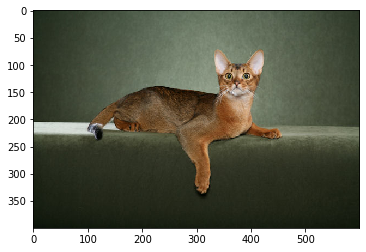

In [3]:
plt.imshow( img )

In [4]:
# 头部轮廓信息读取：
xml = open( 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls/Abyssinian_1.xml' ).read()

In [5]:
# 文本内容抓取：
select = etree.HTML(xml)
type(select)

lxml.etree._Element

In [6]:
# 在size分支下，抓取width和height标签的数据：开头必须是// ！
width = select.xpath( '//size/width/text()' )[0]      # 宽是x向
height = select.xpath( '//size/height/text()' )[0]    # 高是y向
width, height

('600', '400')

In [7]:
# 在bndbox分支下，抓取xmin、xmax、ymin、ymax标签的数据：开头必须是// ！
xmin = select.xpath( '//bndbox/xmin/text()' )[0]
xmax = select.xpath( '//bndbox/xmax/text()' )[0]
ymin = select.xpath( '//bndbox/ymin/text()' )[0]
ymax = select.xpath( '//bndbox/ymax/text()' )[0]
xmin, xmax, ymin, ymax

('333', '425', '72', '158')

In [8]:
# 把上面抓取的信息全部全部转为int数据类型：
width = int( width ); height = int( height );
xmin = int( xmin ); xmax = int( xmax ); ymin = int( ymin ); ymax = int( ymax )

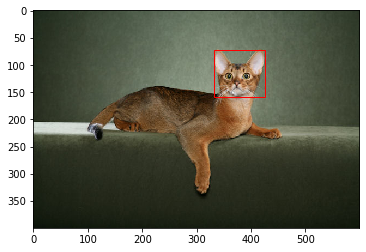

In [9]:
# 用正方形矩形框在原图中圈出：
from matplotlib.patches import Rectangle  # 画矩形框的！ (左下角坐标, x向宽度, y向高度, 框内是否填充, 框线是什么颜色)
Rect = Rectangle( (xmin,ymin), (xmax-xmin), (ymax-ymin), fill = False, color = 'r' ) 

plt.imshow( img )
ax = plt.gci()  # gci = get current image：获得当前图像的句柄，即后面操作还在当前图上进行
ax.axes.add_patch( Rect )
plt.show()

## 2. 图像预处理：

难点：图像大小不一，每个图像头部**4个参考点的位置都是和原图尺寸相关**的！—— 即：如果直接统一图片的尺寸，那么原始的头部4个参考点就不对了！

解决：比例是不会变的！把原始坐标调成相对于x、y轴的“**比例**”坐标！—— 图片要进行的**等比例缩放tf.image.resize()**！

---

注意：
- 用tf.image.resize()处理后的矩阵/图片，其内部数值最好先调成float！—— 之前也说过！
- 图像的3维记录顺序：**(h, w, c) = (高度y, 宽度x, 通道数)**

In [10]:
# 先标准化：
img = img / 255

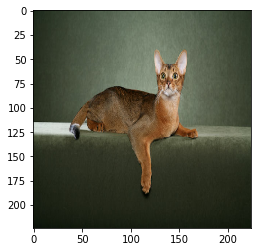

In [11]:
new_height = 224
new_width = 224  
# 等比例放缩放(224,224)：
img = tf.image.resize(img, [new_height,new_width])  # 先高度，再宽度
plt.imshow(img) 

In [12]:
# 4个头部控制点也按同比例放缩：
xmin = ( xmin / width ) * new_width
xmax = ( xmax / width ) * new_width

ymin = ( ymin / height ) * new_height
ymax = ( ymax / height ) * new_height

xmin, xmax, ymin, ymax

(124.32000000000001, 158.66666666666669, 40.32, 88.48)

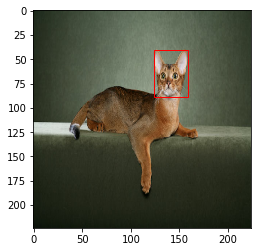

In [13]:
# 再画一次看看：
Rect = Rectangle( (xmin,ymin), (xmax-xmin), (ymax-ymin), fill = False, color = 'r' ) 
plt.imshow( img )
ax = plt.gci()  # gci = get current image：获得当前图像的句柄，即后面操作还在当前图上进行
ax.axes.add_patch( Rect )
plt.show()

## 3. 获取对应文件的地址：

难点：标签数和图像数不一致，需要验证名字是否相互匹配！

解决：有标签的都当作训练数据，其他都是测试数据；验证训练数据与标签是否对应，可以用排序后的结果要查看！

In [14]:
# 获取所有图片地址：
images_path = glob.glob( 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images/*.jpg' )
len(images_path)

7390

In [15]:
# 查看一下：
images_path[0:5]

['E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_1.jpg',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_10.jpg',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_100.jpg',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_101.jpg',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_102.jpg']

In [16]:
# 获取所有图像的头部控制点坐标.xml文件：
xmls_path = glob.glob( 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls/*.xml' )
len(xmls_path)

3686

In [17]:
# 查看一下：
xmls_path[0:5]

['E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_1.xml',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_10.xml',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_100.xml',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_101.xml',
 'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_102.xml']

In [18]:
# 把标签提取出来：中间变量！
xmls_names = [ x.split('\\')[1].split('.')[0] for x in xmls_path ]
xmls_names[0:5]

['Abyssinian_1',
 'Abyssinian_10',
 'Abyssinian_100',
 'Abyssinian_101',
 'Abyssinian_102']

In [19]:
# 获得训练数据（地址）：
train_images_path = [ img for img in images_path if img.split('\\')[1].split('.')[0] in xmls_names ]
len(train_images_path)

3686

In [20]:
# 获得测试数据（地址）：无.xml文件对应！
test_images_path = [ img for img in images_path if img.split('\\')[1].split('.')[0] not in xmls_names ]
len(test_images_path)

3704

In [21]:
# 验证train的其标签是否对应：根据名词进行排序
train_images_path.sort( key = lambda x:x.split('\\')[1].split('.')[0] )
xmls_path.sort( key = lambda x:x.split('\\')[1].split('.')[0] )

In [22]:
train_images_path[23:28], xmls_path[23:28]

(['E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_120.jpg',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_121.jpg',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_122.jpg',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_123.jpg',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/images\\Abyssinian_124.jpg'],
 ['E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_120.xml',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_121.xml',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_122.xml',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_123.xml',
  'E:/tensorflow2.0_日月光华/日月光华-tensorflow资料/数据集/图片定位与分割数据集/annotations/xmls\\Abyssinian_124.xml'])

In [ ]:
# 后面有用的变量：
train_images_path
test_images_path 
xmls_path

## 4. 解析所有图片的.xml文件中4个控制参数坐标 + tf.dataset：

In [23]:
def to_label(path):
    xml = open(r'{}'.format(path)).read()  # 给一个地址即可！
    select = etree.HTML(xml)
    height = int( select.xpath('//size/height/text()')[0] )
    width = int( select.xpath('//size/width/text()')[0] )
    xmin = int( select.xpath('//bndbox/xmin/text()')[0] )
    ymin = int( select.xpath('//bndbox/ymin/text()')[0] )
    xmax = int( select.xpath('//bndbox/xmax/text()')[0] )
    ymax = int( select.xpath('//bndbox/ymax/text()')[0] )
    return [ xmin/width, ymin/height, xmax/width, ymax/height ]  # 相对位置

In [24]:
# （训练集）图片的控制点坐标提取：
points_label = [ to_label(path) for path in xmls_path ]   # 两层嵌套列表！

In [25]:
points_label[0:3]

[[0.555, 0.18, 0.7083333333333334, 0.395],
 [0.192, 0.21, 0.768, 0.582],
 [0.383248730964467, 0.142, 0.850253807106599, 0.534]]

In [26]:
# 应该变形：[ [所有图的xmin], [所有图的ymin], [所有图的xmax], [所有图的ymax] ] —— zip的反操作！
outs_xmin, outs_ymin, outs_xmax, outs_ymax = list( zip(*points_label) )
outs_xmin[0:3], type(outs_xmin)

((0.555, 0.192, 0.383248730964467), tuple)

In [27]:
# 要放入tf.data.Dataset()中，要把它们转为tensor或array：
outs_xmin = np.array( outs_xmin )
outs_ymin = np.array( outs_ymin )
outs_xmax = np.array( outs_xmax )
outs_ymax = np.array( outs_ymax )

In [28]:
# 这全是训练集的标签！
label_dataset = tf.data.Dataset.from_tensor_slices( (outs_xmin, outs_ymin, outs_xmax, outs_ymax) )
label_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.float64, tf.float64, tf.float64, tf.float64)>

## 5. 创建所有图片的dataset：

In [29]:
def load_image(path):
    image = tf.io.read_file( path )
    image = tf.image.decode_jpeg( image, channels = 3 )
    image = tf.image.resize( image, [new_height, new_width] )
    image = image / 127.5 - 1  # 归一化到[-1,1]
    return image

In [30]:
train_images = tf.data.Dataset.from_tensor_slices( train_images_path )
train_images = train_images.map( load_image )
train_images

<MapDataset shapes: (224, 224, 3), types: tf.float32>

In [31]:
train_dataset = tf.data.Dataset.zip( (train_images, label_dataset) )
train_dataset

<ZipDataset shapes: ((224, 224, 3), ((), (), (), ())), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64))>

In [32]:
# 乱序、划分batch：
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(len(train_images_path)).repeat().batch(BATCH_SIZE)

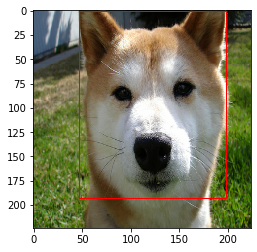

In [33]:
# 取出“一张”图查看：
for image, label in train_dataset.take(1):  # 提取的是一个batch！
    plt.imshow(tf.keras.preprocessing.image.array_to_img( image[0] ) )
    out1, out2, out3, out4 = label
    xmin, ymin, xmax, ymax = out1[0].numpy()*new_width, out2[0].numpy()*new_height, out3[0].numpy()*new_width, out4[0].numpy()*new_height
    
    ax = plt.gci()  # gci = get current image：获得当前图像的句柄，即后面操作还在当前图上进行
    Rect = Rectangle( (xmin,ymin), (xmax-xmin), (ymax-ymin), fill = False, color = 'r' ) 
    ax.axes.add_patch( Rect )
    plt.show()

说明：这个标框偏了我觉得才是正常的！因为resize的局限性导致图片不是按我们计划的“**等比例缩放**”进行的！

In [34]:
image[0].shape

TensorShape([224, 224, 3])

In [ ]:
# 后面有用的变量：
train_dataset

## 6. 模型创建：

说明：分类任务一般使用预训练网络，本例使用Xception！

In [46]:
xception = tf.keras.applications.Xception( weights = 'imagenet', include_top = False, input_shape = (224,224,3) )

In [47]:
# 所有分支前共有的部分：
inputs = tf.keras.layers.Input( shape = (224,224,3) )
x = xception(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  
x = tf.keras.layers.Dense( 2048, activation = 'relu' )(x)
x = tf.keras.layers.Dense( 256, activation = 'relu' )(x)

In [48]:
# 4个回归分支（无需激活）：xmin、ymin、xmax、ymax
out_xmin = tf.keras.layers.Dense(1, name = 'out_xmin')(x)
out_ymin = tf.keras.layers.Dense(1, name = 'out_ymin')(x)
out_xmax = tf.keras.layers.Dense(1, name = 'out_xmax')(x)
out_ymax = tf.keras.layers.Dense(1, name = 'out_ymax')(x)

prediction = [out_xmin, out_ymin, out_xmax, out_ymax]

In [49]:
# 模型搭建：
model = tf.keras.models.Model( inputs = inputs, outputs = prediction )

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 7, 7, 2048)   20861480    input_8[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 2048)         4196352     global_average_pooling2d_3[0][0] 
____________________________________________________________________________________________

In [51]:
# 模型编译：学习率小一点！
model.compile(
    tf.keras.optimizers.Adam( lr = 0.0001 ),  # 全局优化：只有一个！
    loss = {'out_xmin':'mse', 'out_ymin':'mse', 'out_xmax':'mse', 'out_ymax':'mse'},
    metrics = ['mae']  # 用平均绝对误差！
)

In [ ]:
# 训练：
EPOCHES = 50
history = model.fit(
    train_dataset,
    epochs = EPOCHES,
    steps_per_epoch = len(train_images_path) // BATCH_SIZE,
)

## 7. 模型保存：

In [ ]:
model.save( 'epoch30.h5' )

## 8. 模型预测：

In [ ]:
# 先把模型导入：
new_model = tf.keras.models.load_model( 'epoch30.h5' )

In [ ]:
# 画图进行预测：
plt.figure(figsize=(8, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4 = new_model.predict(img)
    # 查看6张图：
    for i in range(6):
        plt.subplot(6, 1, i+1)  # 注意：子图数值是从1开始的！不是从0
        plt.imshow( tf.keras.preprocessing.image.array_to_img(img[i]) )  # 将张量转为array
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224
        rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
        ax = plt.gca()
        ax.axes.add_patch(rect)

## 9. 模型优化：

当前模型的显著缺点如下：
- 泛化能力不强：如果特征物体和背景信息很相似，那么会导致定位不准确；
- 只能预测一个物体的头部；若图中出现多个物体时，无法都进行定位！

单实例（本例）定位的应用：
- 门禁系统每次仅识别一个人：算法仅分析摄像头中的一个物体，不可能一次定位多个！—— 另外，先定位，再进行人脸识别（分类），会比直接进行对原图进行人脸识别精度要高（没有背景噪声的影响）！
- 单人体姿态估计：关键点定位 —— 只不过点数比4个多而已，还是多分支的回归问题。

---

图像定位的优化思路：
- 先大后小：先在整张图片中预测出关键点，然后再在预测出的关键点的周边，进行二次预测；这样的可以获得更加精确的定位结果。
- 滑动窗口的方式：用一个小的窗口在图片上进行滑动，滑动的过程中每次做两个预测：1. 是否要需要的关键点；2. 关键点的位置 —— 可以进行多物体的同时预测 + 定位。

针对不定个数的预测问题：
- 先检测出多个对象，再在多个对象上进行回归定位；
- 尝试使用全卷积网络：去掉全链接层，把最后的回归问题直接转为分类问题 —— 语义分割

图像定位的评价标准：IoU（交并比）—— 预测边框和真实边框的交集和并集的比值（准确率最高时，IoU = 1）